<a href="https://colab.research.google.com/github/dsw2xxx/nlp-mimic-III/blob/main/GP_1_tutorial_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

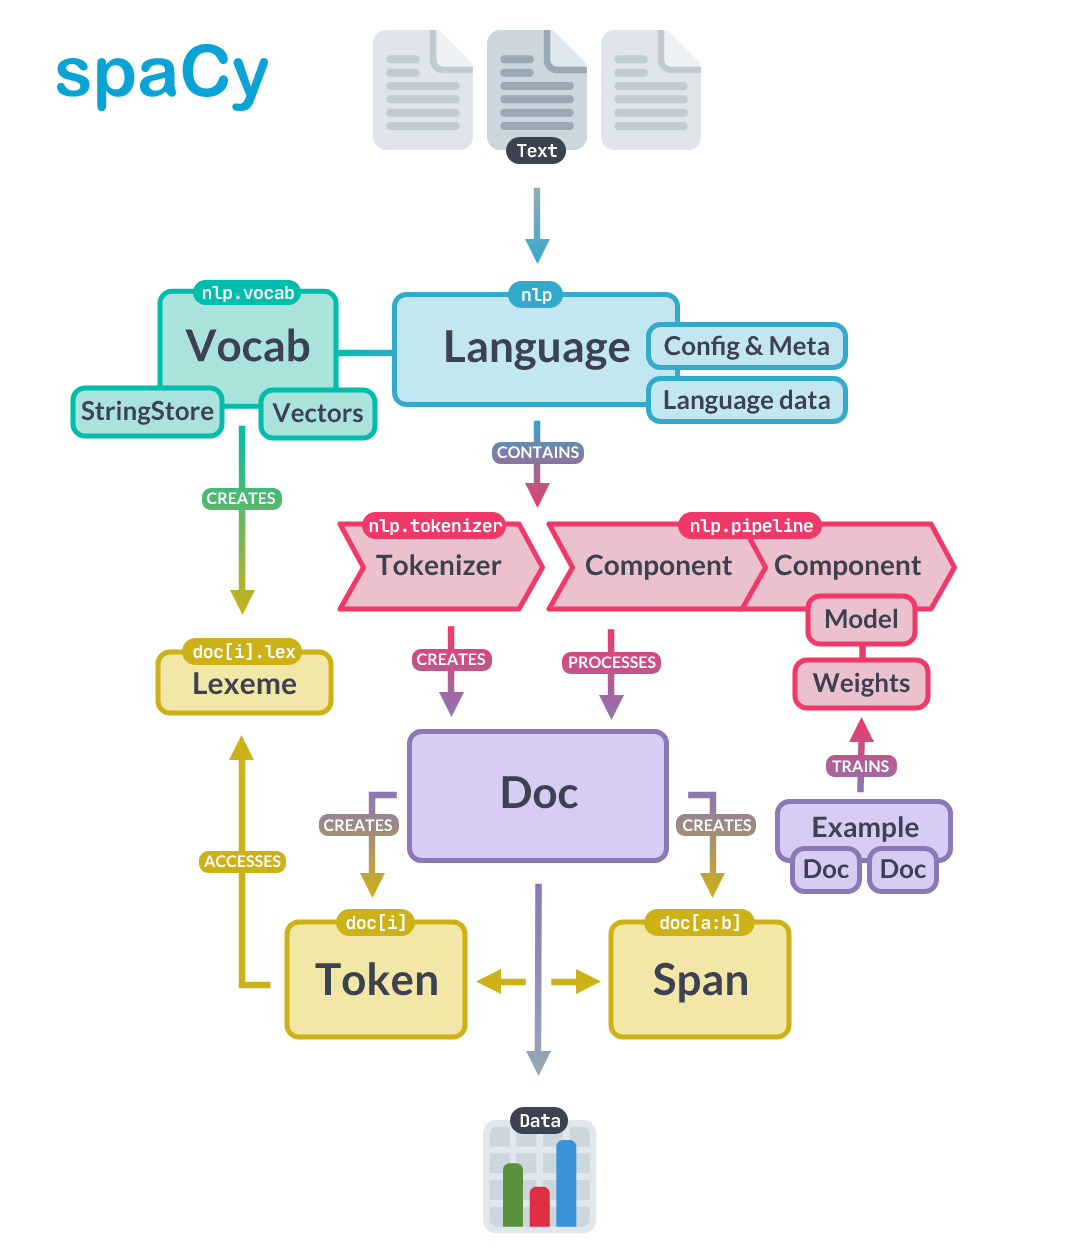

In [ ]:
! pip install -U pip setuptools wheel &> /dev/null
! pip install -U spacy &> /dev/null
! python -m spacy download en_core_web_lg &> /dev/null

! pip install scispacy &> /dev/null
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_scibert-0.4.0.tar.gz &> /dev/null
#! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_craft_md-0.4.0.tar.gz &> /dev/null
#! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_jnlpba_md-0.4.0.tar.gz &> /dev/null
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz &> /dev/null
#! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz &> /dev/null
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz &> /dev/null

# Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

## MIMIC-III: ADMISSIONS.csv

In [ ]:
dt_admissions = pd.read_csv('/content/drive/MyDrive/UT Austin/Spring-2021/AI in Health/mimic-iii-clinical-database-1.4/ADMISSIONS.csv')
print(dt_admissions.shape)
dt_admissions.head()

(58976, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


## MIMIC-III: NOTEEVENTS.csv

In [ ]:
dt_noteevents = pd.read_csv('/content/drive/MyDrive/UT Austin/Spring-2021/AI in Health/mimic-iii-clinical-database-1.4/NOTEEVENTS.csv')
print(dt_noteevents.shape)
dt_noteevents.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2083180, 11)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


## Merge ADMISSIONS.csv and NOTEEVENTS.csv

In [ ]:
col_merged = ['SUBJECT_ID', 'HADM_ID', 'DIAGNOSIS', 'ETHNICITY', 'TEXT']

dt = pd.merge(dt_admissions, dt_noteevents, how='left', on=['SUBJECT_ID', 'HADM_ID'])[col_merged].drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID'], keep='first', ignore_index=True)
#dt = pd.merge(dt_admissions, dt_noteevents, how='right', on=['SUBJECT_ID', 'HADM_ID'])[col_merged]
print(dt.shape)
dt.head()

(58976, 5)


,SUBJECT_ID,HADM_ID,DIAGNOSIS,ETHNICITY,TEXT
0,22,165315,BENZODIAZEPINE OVERDOSE,WHITE,Admission Date: [**2196-4-9**] Discharg...
1,23,152223,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,WHITE,Admission Date: [**2153-9-3**] D...
2,23,124321,BRAIN MASS,WHITE,Admission Date: [**2157-10-18**] ...
3,24,161859,INTERIOR MYOCARDIAL INFARCTION,WHITE,Admission Date: [**2139-6-6**] D...
4,25,129635,ACUTE CORONARY SYNDROME,WHITE,Admission Date: [**2160-11-2**] ...


# Preprocess Dataset

## Column: ETHNICITY

In [ ]:
dt['ETHNICITY'].unique()

array(['WHITE', 'UNKNOWN/NOT SPECIFIED', 'MULTI RACE ETHNICITY',
       'BLACK/AFRICAN AMERICAN', 'HISPANIC OR LATINO',
       'PATIENT DECLINED TO ANSWER', 'ASIAN', 'OTHER',
       'HISPANIC/LATINO - GUATEMALAN', 'ASIAN - VIETNAMESE',
       'AMERICAN INDIAN/ALASKA NATIVE', 'WHITE - RUSSIAN',
       'HISPANIC/LATINO - PUERTO RICAN', 'ASIAN - CHINESE',
       'ASIAN - ASIAN INDIAN', 'BLACK/AFRICAN',
       'HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - DOMINICAN',
       'UNABLE TO OBTAIN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN',
       'WHITE - OTHER EUROPEAN', 'PORTUGUESE', 'SOUTH AMERICAN',
       'WHITE - EASTERN EUROPEAN', 'CARIBBEAN ISLAND', 'ASIAN - FILIPINO',
       'ASIAN - CAMBODIAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
       'WHITE - BRAZILIAN', 'ASIAN - KOREAN',
       'HISPANIC/LATINO - COLOMBIAN', 'ASIAN - JAPANESE',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'ASIAN - THAI',
       'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - CUBAN',
       'MID

In [ ]:
dt['ETHNICITY'].replace('^WHITE\D*', 'WHITE', regex=True, inplace=True)
dt['ETHNICITY'].replace('^BLACK\D*', 'BLACK', regex=True, inplace=True)
dt['ETHNICITY'].replace('^HISPANIC\D*', 'HISPANIC/LATINO', regex=True, inplace=True)
dt['ETHNICITY'].replace('^ASIAN\D*', 'ASIAN', regex=True, inplace=True)
dt.loc[~dt['ETHNICITY'].isin(['WHITE', 'BLACK', 'HISPANIC/LATINO', 'ASIAN']), 'ETHNICITY'] = 'UNKNOWN/NOT SPECIFIED'

In [ ]:
dt['ETHNICITY'].unique()

array(['WHITE', 'UNKNOWN/NOT SPECIFIED', 'BLACK', 'HISPANIC/LATINO',
       'ASIAN'], dtype=object)

To examine similarity between documents, we need to compare word vectors or “word embeddings” which is multi-dimensional meaning representations of a word.

Word vectors can be generated using an algorithm like word2vec and usually look like this:

In [ ]:
import scispacy
import spacy

#nlp = spacy.load('en_core_web_lg') # spacy
nlp = spacy.load('en_core_sci_lg') # scispacy
#nlp = spacy.load('en_core_sci_scibert') # scispacy
#nlp = spacy.load('en_ner_bc5cdr_md')

# Extract sub-dataframe: Pneumonia

In [ ]:
dt_pneumonia = dt.loc[dt['DIAGNOSIS'] == 'PNEUMONIA'].reset_index(drop=True)
dt_pneumonia

,SUBJECT_ID,HADM_ID,DIAGNOSIS,ETHNICITY,TEXT
0,357,101651,PNEUMONIA,WHITE,Admission Date: [**2199-10-20**] ...
1,368,105889,PNEUMONIA,WHITE,Admission Date: [**2137-7-11**] Discharge...
2,368,138061,PNEUMONIA,WHITE,Admission Date: [**2139-12-16**] ...
3,370,123421,PNEUMONIA,WHITE,Admission Date: [**2153-3-4**] Discharg...
4,68,170467,PNEUMONIA,BLACK,Admission Date: [**2173-12-15**] ...
...,...,...,...,...,...
1561,96244,186668,PNEUMONIA,WHITE,Admission Date: [**2184-2-1**] D...
1562,96260,146313,PNEUMONIA,BLACK,Admission Date: [**2194-12-12**] ...
1563,90688,107472,PNEUMONIA,WHITE,Admission Date: [**2153-10-9**] ...
1564,98649,110990,PNEUMONIA,ASIAN,Admission Date: [**2122-6-20**] ...


## Number of Patients per race


In [ ]:
# ['UNKNOWN/NOT SPECIFIED', 'WHITE', 'HISPANIC/LATINO', 'BLACK', 'ASIAN']
print('WHITE: {} | BLACK: {} | HISPANIC/LATINO: {} | ASIAN: {} | UNKNOWN/NOT SPECIFIED: {}'.\
      format(len(dt_pneumonia.loc[dt_pneumonia['ETHNICITY'] == 'WHITE']),
             len(dt_pneumonia.loc[dt_pneumonia['ETHNICITY'] == 'BLACK']),
             len(dt_pneumonia.loc[dt_pneumonia['ETHNICITY'] == 'HISPANIC/LATINO']),
             len(dt_pneumonia.loc[dt_pneumonia['ETHNICITY'] == 'ASIAN']),
             len(dt_pneumonia.loc[dt_pneumonia['ETHNICITY'] == 'UNKNOWN/NOT SPECIFIED'])))

WHITE: 1178 | BLACK: 183 | HISPANIC/LATINO: 58 | ASIAN: 54 | UNKNOWN/NOT SPECIFIED: 93


In [ ]:
dt_pneumonia['TEXT'].isnull().sum()

12

In [ ]:
dt_pneumonia.loc[(dt_pneumonia['TEXT'] == ''), 'TEXT']

Series([], Name: TEXT, dtype: object)

In [ ]:
dt_pneumonia.loc[(dt_pneumonia['TEXT'].isnull() == True), 'TEXT']

885     NaN
895     NaN
1078    NaN
1159    NaN
1164    NaN
1184    NaN
1190    NaN
1238    NaN
1276    NaN
1324    NaN
1472    NaN
1504    NaN
Name: TEXT, dtype: object

In [ ]:
dt_pneumonia.loc[(dt_pneumonia['TEXT'].isnull() == True), 'TEXT'] = 'NOTE might be missing.'

In [ ]:
dt_pneumonia['TEXT'].isnull().sum()

0

In [ ]:
dt_pneumonia.loc[35, 'TEXT'][1368:1600]

'c low grade, benign mucinous cystic neoplasm (LGBMC)\nLarge bilateral renal cysts\nSmall AAA\nPopliteal aneurysm\nhyperuricosuria\nrestless leg syndrome\nGERD\n\nSocial History:\nWorks as a software engineer.  Is married with no children.\nDe'

In [ ]:
doc

Admission Date:  [**2139-12-5**]              [**Month/Day/Year **] Date:   [**2139-12-5**]

Date of Birth:  [**2057-5-11**]             Sex:   F

Service: MEDICINE

Allergies:
Aspirin / Bactrim / Nsaids

Attending:[**Last Name (NamePattern4) 290**]
Chief Complaint:
Altered mental status

Major Surgical or Invasive Procedure:
None

History of Present Illness:
This is an 82 yo female w/ bronchiectasis, CHF and COPD who
presents with an acute change in mental status (became
nonverbal). On EMS arrival to her home, she was found to be
cyanotic and in respiratory distress. Was placed on NRB with
sats to 90s. Family states she had a sore throat yesterday, but
no cough or SOB that they noted. Also mention in records of ear
pain and odynophagia last night, as well as chills.

In the ED, initial VS: T 98.7 75/39 79 20 80s RA -> high 90s
NRB. Placed on BiPAP, satting 100%. Patient told EMS she did not
want to be intubated. ED paged her pulmonologist [**First Name4 (NamePattern1) **] [**Last Name

In [ ]:
doc = nlp(dt_pneumonia.loc[117, 'TEXT'])
doc[1585:1800].text

'Medications on Admission:\nALBUTEROL SULFATE [PROAIR HFA] - 90 mcg HFA Aerosol Inhaler - 2\n(Two) puffs by mouth every four (4)  to six (6) hours as needed\nfor cough/wheezing\nALENDRONATE [FOSAMAX] - 70 mg Tablet - 1 Tablet(s) by mouth q\nweek\nCITALOPRAM [CELEXA] - 20 mg Tablet - 3 Tablet(s) by mouth once a\nday\nFLUTICASONE-SALMETEROL [ADVAIR DISKUS] - 250 mcg-50 mcg/Dose\nDisk\nwith Device - 1 puff inhaled twice a day rinse after use\nFUROSEMIDE [LASIX] - 20 mg Tablet - 0.5 (One half) Tablet(s) by\nmouth once a day and increase as directed by Dr [**Last Name (STitle) **]\nLISINOPRIL - 5 mg Tablet - [**12-20**] Tablet(s) by mouth once a day\nLORAZEPAM - 0.5 mg Tablet - [**12-20**] Tablet(s) by mouth qhs  as\nneeded\nfor sleep\nSIMVASTATIN - 20 mg Tablet - 1 Tablet(s) by mouth once a day\nSPIRONOLACTONE - 25'

# Compare Similarity Score

In [ ]:
col_medications = []

#for i in range(len(dt_pneumonia)):
#for i in range(10):
for i in range(len(dt_pneumonia)):
  doc = nlp(dt_pneumonia.loc[i, 'TEXT'])
  #print(doc)
  idx_start = 0
  idx_end = 0
  for j in range(len(doc)):
    #idx_start = 0
    #idx_end = 0
    if (doc[j].text == 'Medications') and (doc[j+1].text == 'on') and (doc[j+2].text == 'Admission'):
      idx_start = j
      #print('A')
      #print('B')
      #print('-------------------------------------------------------')
    if (doc[j].text == 'Discharge') and (doc[j+1].text == 'Medications'):
      idx_end = j
      #print('C')
      #print('-------------------------------------------------------')
    if (doc[j].text == '\n\n\n'):
      idx_end = j
  if (idx_start == 0) and (idx_end == 0):
    col_medications.append('No Medication Information')
  else:
    if doc[idx_start:idx_end].text != '':
      col_medications.append(doc[idx_start:idx_end].text)
    else:
      print(i, j)
      print(idx_start, idx_end)
      print('\n')
  #print(doc[idx_start:idx_end].text)
  #for z in range(len(dt_pneumonia)):
  #  if i != z:
  #    doc[idx_start:idx_end].text

117 2079
1585 0


324 3457
3366 3365




In [ ]:
col_medications = []

#for i in range(len(dt_pneumonia)):
#for i in range(10):
for i in range(len(dt_pneumonia)):
  doc = nlp(dt_pneumonia.loc[i, 'TEXT'])
  tokens = [token for token in doc if not token.is_space | token.is_punct]

  idx_start = 0
  idx_end = 0

  for j in range(len(tokens)):

    if (tokens[j].text == 'Medications') and (tokens[j+1].text == 'on') and (tokens[j+2].text == 'Admission'):
      idx_start = j

    if (tokens[j].text == 'Discharge') and (tokens[j+1].text == 'Medications'):
      idx_end = j

  if (idx_start == 0) and (idx_end == 0):
    col_medications.append('No Medication Information')
  else:
    if doc[idx_start:idx_end].text != '':
      col_medications.append(doc[idx_start:idx_end].text)

    else:
      print(i)
      print(idx_start, idx_end)
      print('\n')

35
941 0


67
1277 0


77
894 0


79
945 0


117
985 0


126
1186 0


141
1218 0


149
1357 0


179
4300 0


199
2484 0


224
1981 0


225
1004 0


281
1427 0


305
2311 0


308
1125 0


324
2261 0


349
1723 0


350
1476 0


369
1472 0


370
2014 0


373
1147 0


381
2126 0


387
1696 0


389
1151 0


390
1621 0


391
1041 0


450
898 0


480
973 0


517
686 0


525
2039 0


526
1299 0


542
286 0


578
2318 0


585
1031 0


607
2524 0


644
1042 0


667
1221 0


668
651 0


692
1322 0


708
1369 0


722
1733 0


729
376 0


733
2695 0


745
1581 0


747
1703 0


761
797 0


762
1714 0


783
1194 0


816
969 0


861
1292 0


888
1235 0


907
1346 0


910
1045 0


914
1161 0


944
1544 0


955
1617 0


978
1757 0


997
1879 0


1048
1163 0


1075
1644 0


1087
854 0


1089
1107 0


1124
948 0


1134
1318 0


1163
1054 0


1167
2230 0


1192
2027 0


1231
1490 0


1271
821 0


1280
1936 0


1333
1794 0


1335
628 0


1336
1548 0


1346
1278 0


1365
1216 0


1376
2469 0


1383
1499 0




117 2079
1585 0


324 3457
3366 3365


In [ ]:
col_medications

['Medications on Admission:\nTopiramate 100 mg PO BID\nMetoprolol 25 mg PO BID\nLevetiracetam PO BID\nZonisamide 500 mg DAILY\nLevothyroxine PO DAILY\nFluocinolone 0.025 % Cream\nLactulose 10 gram/15 mL Syrup\nRifaximin PO TID\nLorazepam 0.5 mg PO DAILY\nFurosemide 40 mg PO DAILY\nHeparin (Porcine) 5,000 unit/mL\nMultivitamin  PO DAILY\nFolic Acid 1 mg PO DAILY\nLansoprazole 30 mg\nThiamine HCl 100 mg PO DAILY\nPolyvinyl Alcohol 1.4 % Drops\n\n',
 'No Medication Information',
 'Medications on Admission:\n1. Docusate Sodium 100 mg PO BID\n2. Aspirin 81 mg\n3. Clopidogrel 75 mg DAILY\n4. Fluticasone-Salmeterol 250-50 mcg/Dose Disk with Device Sig:\n\nOne (1) puff Inhalation [**Hospital1 **]\n5. Combivent 103-18 mcg/Actuation Aerosol Sig: One (1) puff\nInhalation every 6-8 hours as needed for shortness of breath or\n\nwheezing.\n6. Digoxin 125 mcg DAILY\n7. Isosorbide Mononitrate 30 mg Tablet Sustained Release 24HR\nDAILY.\n8. Pantoprazole 40 mg PO Q12H.\n9. Risperidone 0.5 mg PO HS\n10. 

In [ ]:
len(col_medications)

1566

In [ ]:
col_medications[2][0]

'M'

In [ ]:
col_medications[35] == ''

True

In [ ]:
tmp = []
for i in range(len(col_medications)):
  #print(i)
  #print(col_medications[i][0])
  if (col_medications[i][0] != 'M') or (col_medications[i][0] == 'M'):
    print(i)
    #tmp.append(i)
  else:
    print(col_medications[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


IndexError: ignored

In [ ]:
len(tmp)

1566

In [ ]:
dt_pneumonia['TEXT_Medications'] = col_medications
dt_pneumonia

,SUBJECT_ID,HADM_ID,DIAGNOSIS,ETHNICITY,TEXT,TEXT_Medications
0,357,101651,PNEUMONIA,WHITE,Admission Date: [**2199-10-20**] ...,Medications on Admission:\nTopiramate 100 mg P...
1,368,105889,PNEUMONIA,WHITE,Admission Date: [**2137-7-11**] Discharge...,patient has a history of anxiety that had\nbee...
2,368,138061,PNEUMONIA,WHITE,Admission Date: [**2139-12-16**] ...,Medications on Admission:\n1. Docusate Sodium ...
3,370,123421,PNEUMONIA,WHITE,Admission Date: [**2153-3-4**] Discharg...,drink as tolerated.\n\n7. Code status: The p...
4,68,170467,PNEUMONIA,BLACK,Admission Date: [**2173-12-15**] ...,Medications on Admission:\nEmtriva 200mg daily...
...,...,...,...,...,...,...
1561,96244,186668,PNEUMONIA,WHITE,Admission Date: [**2184-2-1**] D...,Medications on Admission:\nLasix 40mg PO daily...
1562,96260,146313,PNEUMONIA,BLACK,Admission Date: [**2194-12-12**] ...,Medications on Admission:\n- infliximab 7.4mg/...
1563,90688,107472,PNEUMONIA,WHITE,Admission Date: [**2153-10-9**] ...,Medications on Admission:\nAlendronate 70mg PO...
1564,98649,110990,PNEUMONIA,ASIAN,Admission Date: [**2122-6-20**] ...,Medications on Admission:\n1. Hydromorphine 2m...


In [ ]:
dt_pneumonia.loc[dt_pneumonia['TEXT_Medications'] == '']

,SUBJECT_ID,HADM_ID,DIAGNOSIS,ETHNICITY,TEXT,TEXT_Medications
14,224,169158,PNEUMONIA,WHITE,Sinus rhythm. Atrial premature beats. Prolonge...,
16,283,109185,PNEUMONIA,WHITE,Admission Date: [**2166-8-12**] Dischar...,
29,726,148109,PNEUMONIA,WHITE,Admission Date: [**2123-7-1**] Discharge ...,
30,770,140093,PNEUMONIA,WHITE,Admission Date: [**2127-1-28**] Dischar...,
31,773,171563,PNEUMONIA,WHITE,Admission Date: [**2103-7-19**] Dischar...,
...,...,...,...,...,...,...
1336,76056,192459,PNEUMONIA,WHITE,Admission Date: [**2118-2-13**] ...,
1376,86648,121994,PNEUMONIA,WHITE,Admission Date: [**2187-4-2**] [...,
1472,94916,162540,PNEUMONIA,WHITE,NOTE might be missing.,
1487,93113,172646,PNEUMONIA,UNKNOWN/NOT SPECIFIED,Admission Date: [**2112-7-6**] D...,


In [ ]:
patients = []

#for i in range(len(dt_pneumonia)):
for i in range(0, len(dt_pneumonia), 597):
  #if i < 50: # Use 50 rows for test

  doc = nlp(dt_pneumonia.loc[i, 'TEXT'])
  #docs.append(doc)
  #doc = nlp(dt_notes['TEXT'][i])
  #tokens = [token for token in doc if not token.is_space | token.is_punct | token.is_stop]
  
  #patients.append(dt.loc[i, dt.loc[i, dt.columns.drop(['TEXT']).tolist()].append(doc)])
  patients.append({'SUBJECT_ID': dt_pneumonia.loc[i, 'SUBJECT_ID'],
                    'HADM_ID': dt_pneumonia.loc[i, 'HADM_ID'],
                    'DIAGNOSIS': dt_pneumonia.loc[i, 'DIAGNOSIS'],
                    'ETHNICITY': dt_pneumonia.loc[i, 'ETHNICITY'],
                    'TEXT': doc})

  #docs.append(dt.loc[i].to_dict())

In [ ]:
cnt_white = 0
cnt_black = 0
cnt_hispanic = 0
cnt_asian = 0
cnt_unknown = 0

for i in range(len(patients)):
  if patients[i]['ETHNICITY'] == 'WHITE':
    cnt_white += 1
  elif patients[i]['ETHNICITY'] == 'BLACK':
    cnt_black += 1
  elif patients[i]['ETHNICITY'] == 'HISPANIC/LATINO': 
    cnt_hispanic += 1
  elif patients[i]['ETHNICITY'] == 'ASIAN':
    cnt_asian += 1
  elif patients[i]['ETHNICITY'] == 'UNKNOWN/NOT SPECIFIED':
    cnt_unknown += 1

print(cnt_white, cnt_black, cnt_hispanic, cnt_asian, cnt_unknown)

77 11 3 3 7


In [ ]:
for i in range(len(patients)):
  patient_a = i
  ls_similarity = []
  for j in range(len(patients)):
    if i != j:
      patient_b = j
      #if patients[i]['TEXT'].similarity(patients[j]['TEXT']) < 0.5:
      ls_similarity.append(patients[i]['TEXT'].similarity(patients[j]['TEXT']))
      #print('Similarity score between doc #{} and doc #{} is {}'.format(i, j, patients[i]['TEXT'].similarity(patients[j]['TEXT'])))
    else:
      ls_similarity.append(2)
  print('The lowest similiarity score between patinent {} and patient {} is {}'.\
        format(patients[i]['ETHNICITY'], patients[ls_similarity.index(min(ls_similarity))]['ETHNICITY'], min(ls_similarity)))

In [ ]:
dt_pneumonia

,SUBJECT_ID,HADM_ID,DIAGNOSIS,ETHNICITY,TEXT
0,99091,185274.0,PNEUMONIA,BLACK,Admission Date: [**2190-2-11**] ...
1,99091,185274.0,PNEUMONIA,BLACK,Sinus tachycardia. Compared to the previous t...
2,99091,185274.0,PNEUMONIA,BLACK,[**2190-2-15**] 4:10 AM\n CHEST (PORTABLE AP) ...
3,99091,185274.0,PNEUMONIA,BLACK,[**2190-2-11**] 10:44 AM\n CHEST (PORTABLE AP)...
4,99091,185274.0,PNEUMONIA,BLACK,[**2190-2-16**] 5:46 AM\n CHEST (PORTABLE AP) ...
...,...,...,...,...,...
59722,7492,182547.0,PNEUMONIA,WHITE,Pt intubated at 2300 abg deterioated 7.15/68/...
59723,7492,182547.0,PNEUMONIA,WHITE,"MICU-B, NPN:\nNeuro: Pt. currently not receiv..."
59724,7492,182547.0,PNEUMONIA,WHITE,Respiratory Care\nPt remains mechaniclly venti...
59725,7492,182547.0,PNEUMONIA,WHITE,MICU NPN 0700-1900\n 55 year old woman MICU pt...


In [ ]:
dt_pneumonia.loc[0, 'TEXT']
print(type(dt_pneumonia.loc[0, 'TEXT']))
print(dt_pneumonia.loc[0, 'TEXT'].find('Medications on Admission:'))
print(dt_pneumonia.loc[0, 'TEXT'].find('Discharge Medications:'))
print(dt_pneumonia.loc[0, 'TEXT'][7901])
print(dt_pneumonia.loc[0, 'TEXT'][8079])
print(dt_pneumonia.loc[0, 'TEXT'][7901:8079])

<class 'str'>
7901
8079
M
D
Medications on Admission:
amlodipine 10 mg daily
atenolol-chlorthalidone 100 mg-25 mg 0.5 tablet daily
calcium carbonate-vitamin D3 500 mg (1,250 mg)-400 unit [**Hospital1 **]





In [ ]:
for i in range(100):
  start = dt_pneumonia.loc[i, 'TEXT'].find('Medications on Admission:')
  end = dt_pneumonia.loc[i, 'TEXT'].find('Discharge Medications:')

  #print(dt_pneumonia.loc[i, 'TEXT'][start:end].replace(' ', ''))
  print(dt_pneumonia.loc[i, 'TEXT'][start:end])

In [ ]:
doc = nlp(dt_pneumonia.loc[0, 'TEXT'])

In [ ]:
doc[0:50]

Admission Date:  [**2190-2-11**]              Discharge Date:   [**2190-2-24**]

Date of Birth:  [**2132-12-15**]             Sex

In [ ]:
for i in range(len(doc)):
  if doc[i].text == 'Medications':
    print(i)

1907
1943


In [ ]:
for i in range(len(doc)):
  if (doc[i].text == 'Medications') and (doc[i+1].text == 'on') and (doc[i+2].text == 'Admission'):
    print(i)

for i in range(len(doc)):
  if (doc[i].text == 'Discharge') and (doc[i+1].text == 'Medications'):
    print(i)
#doc[1279:1302]

1907
1942


In [ ]:
print(doc[1907:1942].text)

Medications on Admission:
amlodipine 10 mg daily
atenolol-chlorthalidone 100 mg-25 mg 0.5 tablet daily
calcium carbonate-vitamin D3 500 mg (1,250 mg)-400 unit [**Hospital1 **]





In [ ]:
for i in range(len(patients)):
  patient_a = i
  ls_similarity = []
  for j in range(len(patients)):
    if i != j:
      patient_b = j
      #if patients[i]['TEXT'].similarity(patients[j]['TEXT']) < 0.5:
      ls_similarity.append(patients[i]['TEXT'].similarity(patients[j]['TEXT']))
      #print('Similarity score between doc #{} and doc #{} is {}'.format(i, j, patients[i]['TEXT'].similarity(patients[j]['TEXT'])))
    else:
      ls_similarity.append(2)
  print('The lowest similiarity score between patinent {} and patient {} is {}'.\
        format(patients[i]['ETHNICITY'], patients[ls_similarity.index(min(ls_similarity))]['ETHNICITY'], min(ls_similarity)))

# Tokenize Document

In [ ]:
doc = nlp(dt_pneumonia.loc[0, 'TEXT'])

#tokens = [token for token in doc if not token.is_space | token.is_punct | token.is_stop]
tokens = [token for token in doc if not token.is_space | token.is_punct]

print(tokens)
print(type(tokens[0]))

for i in range(len(tokens)):
  if tokens[i].text == 'Medications':
    print(i)

for i in range(len(tokens)):
  if tokens[i].text == 'Discharge':
    print(i)

[Admission, Date, 2190, 2, 11, Discharge, Date, 2190, 2, 24, Date, of, Birth, 2132, 12, 15, Sex, F, Service, MEDICINE, Allergies, No, Known, Allergies, Adverse, Drug, Reactions, Attending:[**First, Name3, LF, 1257, Chief, Complaint, Dyspnea, Major, Surgical, or, Invasive, Procedure, Bronchoscopy, History, of, Present, Illness, 57, yo, F, with, PMHX, of, HTN, who, presents, with, shortness, of, breath, x, 7, days, worsening, over, the, last, 3, days, Patient, reports, that, she, has, been, feeling, weak, over, the, last, 3, weeks, with, an, unintentional, 10, lb, weight, loss, of, note, over, the, last, 2, months, she, has, lost, 20lbs, 1, week, ago, she, started, feeling, SOB, with, exertion, and, hot, and, cold, but, no, fevers, chills, Then, 3, days, ago, she, began, to, have, a, non-productive, cough, that, left, her, gasping, for, air, worse, at, night, with, belly, racing, which, appears, to, be, belly, breathing, when, pt, demonstrates, this, Patient, denies, nausea, vomiting, ch

In [ ]:
print(tokens[1279:1282])

[Medications, on, Admission]


In [ ]:
print(tokens[1282:1301])

[amlodipine, 10, mg, daily, atenolol-chlorthalidone, 100, mg-25, mg, 0.5, tablet, daily, calcium, carbonate-vitamin, D3, 500, mg, 1,250, mg)-400, unit]


In [ ]:
print(tokens[1302:1304])

[Discharge, Medications]


In [ ]:
@Language.component("set_custom_boundaries")
def set_custom_boundaries(doc):
    for token in doc[:-1]:
        if token.text == "Discharge":
            doc[token.i + 1].is_sent_start = True
    return doc

In [ ]:
tokenized_docs = []

#for i in range(len(dt_pneumonia)):
for i in range(10):
  doc = nlp(dt_pneumonia.loc[i, 'TEXT'])

  tokenized_docs.append([token for token in doc if not token.is_space | token.is_punct | token.is_stop])

for i in range(len(tokenized_docs)):
  for j in range(len(tokenized_docs[i])):
    if tokenized_docs[i][j] == 'Medications on Admission:':
      for t in range(1, 100):
        if tokenized_docs[i][j+t] != 'Discharge Medications'
        print(tokenized_docs[i][j])

# Visualize Named Entitiy

In [ ]:
from spacy import displacy

In [ ]:
#nlp = spacy.load('en_core_web_lg') # spacy
nlp = spacy.load('en_core_sci_lg') # scispacy
#nlp = spacy.load('en_core_sci_scibert') # scispacy
#nlp = spacy.load('en_ner_bc5cdr_md')
nlp.add_pipe("sentencizer")

In [ ]:
for i in range(len(dt_pneumonia)):
  doc = nlp(dt_pneumonia.loc[i, 'TEXT'])

  if i == 0:
    displacy.render(doc, style='ent', jupyter=True)
    break

# Sentence Boundary Detection (SBD)

In [ ]:
for i in range(len(dt_pneumonia)):
  doc = nlp(dt_pneumonia.loc[i, 'TEXT'])
  #if i < 10:
  for sent in doc.sents:
    if 'Medications on Admission:' in sent.text:
      print('Sentence: {}'.format(sent.text))
      print('\n')

Sentence: 

Medications on Admission:
amlodipine 10 mg daily
atenolol-chlorthalidone 100 mg-25 mg 0.5 tablet daily
calcium carbonate-vitamin D3 500 mg (1,250 mg)-400 unit [**Hospital1 **]


Discharge Medications:
1.


Sentence: 

10)Hypothyroidism: Continue levothyroxine

11)Code: Full

12) Comm: [**Name (NI) **] [**First Name8 (NamePattern2) **] [**Name (NI) 46**] [**Telephone/Fax (1) 2373**], daughter/HCP

Medications on Admission:
Medications:
1.


Sentence: 

Medications on Admission:
# Albuterol Sulfate [ProAir HFA] 90 mcg HFA Aerosol Inhaler 2
puffs inhaled every 4 hr as needed for asthma
# Amlodipine 5 mg Tablet 1 (One) Tablet(s) by mouth once a day
# Fluticasone-Salmeterol [Advair Diskus] 500 mcg-50 mcg/Dose
Disk with Device 1 (One) puff twice a day
# Hydrochlorothiazide 25 mg Tablet 1 Tablet(s) by mouth daily

# Lisinopril 40 mg Tablet 1 Tablet(s) by mouth once a day
# Tiotropium Bromide [Spiriva with HandiHaler] 18 mcg Capsule,
w/Inhalation Device one diskus inhaled once a da

KeyboardInterrupt: ignored

In [ ]:
import re

In [ ]:
for i in range(len(dt_pneumonia)):
  doc = nlp(dt_pneumonia.loc[i, 'TEXT'])

  #if i < 10:
  for sent in doc.sents:
    #if 'Medications on Admission:' in sent.text:
    tmp = re.search('Medications on Admission:', sent)
    print('Sentence: {}'.format(tmp.group()))
    print('\n')

TypeError: ignored

## Lemmatization & Part-of-speech(POS) Tags

In [ ]:
"""
Text: The original word text.
Lemma: The base form of the word.
POS: The simple UPOS part-of-speech tag.
Tag: The detailed part-of-speech tag.
Dep: Syntactic dependency, i.e. the relation between tokens.
Shape: The word shape – capitalization, punctuation, digits.
is alpha: Is the token an alpha character?
is stop: Is the token part of a stop list, i.e. the most common words of the language?
"""

text = []
lemma_ = []
lemma = []
pos = []
tag = []
dep = []
shape = []
is_alpha = []
is_stop = []

for tokenied_doc in tokenized_docs[:1]:
  for token in tokenied_doc:
    text.append(token.text)
    lemma_.append(token.lemma_)
    lemma.append(token.lemma)
    pos.append(token.pos_)
    tag.append(token.tag_)
    dep.append(token.dep_)
    shape.append(token.shape_)
    is_alpha.append(token.is_alpha)
    is_stop.append(token.is_stop)

df_lemma_pos = {
        'Text': text,
        'Lemma_': lemma_,
        'Lemma': lemma,
        'POS': pos,
        'Tag': tag,
        'Dep': dep,
        'Shape': shape,
        'is alpha': is_alpha,
        'is stop': is_stop
}

pd.DataFrame(df_lemma_pos).head()

,Text,Lemma_,Lemma,POS,Tag,Dep,Shape,is alpha,is stop
0,Admission,admission,5274023601144403305,NOUN,NN,compound,Xxxxx,True,False
1,Date,date,15387552459474943870,NOUN,NN,dep,Xxxx,True,False
2,2119,2119,12400119890376686965,NUM,CD,npadvmod,dddd,False,False
3,5,5,2090661578966068036,NUM,CD,prep,d,False,False
4,12,12,1124146173557384544,NUM,CD,prep,dd,False,False


In [ ]:
print(spacy.explain('CD'))

cardinal number


## Named Entities

In [ ]:
"""
Text: The original entity text.
Start: Index of start of entity in the Doc.
End: Index of end of entity in the Doc.
Label: Entity label, i.e. type.
"""

text = []
start_char = []
end_char = []
label = []

for i in range(len(dt_notes)):
  doc = nlp(dt_notes[i])

  for ent in doc.ents:
    text.append(ent.text)
    start_char.append(ent.start_char)
    end_char.append(ent.end_char)
    label.append(ent.label_)

df_ents = {
    'Text': text,
    'Start': start_char,
    'End': end_char,
    'Label': label
}

pd.DataFrame(df_ents).head()

,Text,Start,End,Label
0,2079-3-9,100,108,DATE
1,3,357,358,CARDINAL
2,2 years,446,453,DATE
3,RNY,471,474,ORG
4,ED,502,504,ORG


In [ ]:
print(spacy.explain('ORG'))

Companies, agencies, institutions, etc.


## Visualize Dependency & Entity

In [ ]:
from spacy import displacy

In [ ]:
for i in range(len(dt_notes)):
  doc = nlp(dt_notes[i])

  if i == 0:
    displacy.render(doc, style='dep', jupyter=True)
    displacy.render(doc, style='ent', jupyter=True)

# Vocabulary

In [ ]:
for i in range(2):
  doc = nlp(dt_notes[i])

  if i < 1:
    for word in doc:
      lexeme = doc.vocab[word.text]
      #print(lexeme.text, lexeme.orth, lexeme.shape_, lexeme.prefix_, lexeme.suffix_, lexeme.is_alpha, lexeme.is_digit, lexeme.is_title, lexeme.lang_)

    print(doc.vocab.strings['Admission'])
    print(doc.vocab.strings[17456300258599965360])

17456300258599965360
Admission


# Word2Vec

In [ ]:
! pip install gensim &> /dev/null
! pip install --upgrade python-Levenshtein &> /dev/null

In [ ]:
import gensim
from gensim.models import Word2Vec
from multiprocessing import cpu_count

In [ ]:
dt_notes['notes_cleaned'] = dt_notes.apply(lambda x: gensim.utils.simple_preprocess(x))
print(dt_notes['notes_cleaned'][0])

['admission', 'date', 'discharge', 'date', 'date', 'of', 'birth', 'sex', 'service', 'surgery', 'allergies', 'percocet', 'lisinopril', 'attending', 'first', 'name', 'lf', 'chief', 'complaint', 'substernal', 'chest', 'pain', 'major', 'surgical', 'or', 'invasive', 'procedure', 'closure', 'of', 'perforated', 'ulcer', 'partial', 'gastrectomy', 'cholecystectomy', 'omental', 'patch', 'of', 'ulcer', 'history', 'of', 'present', 'illness', 'who', 'is', 'years', 'laparoscopic', 'rny', 'gastric', 'bypass', 'presents', 'to', 'ed', 'after', 'transfer', 'from', 'hospital', 'with', 'ct', 'scan', 'showing', 'mr', 'known', 'lastname', 'reports', 'sudden', 'onset', 'of', 'substernal', 'chest', 'pain', 'at', 'am', 'pain', 'was', 'severe', 'and', 'his', 'first', 'thought', 'was', 'that', 'he', 'was', 'having', 'an', 'mi', 'pain', 'unrelieved', 'with', 'attempt', 'at', 'bowel', 'movement', 'he', 'denies', 'fevers', 'chills', 'nausea', 'vomiting', 'or', 'any', 'other', 'symptoms', 'no', 'radiation', 'of', 't

In [ ]:
w2v_mimic = Word2Vec(sentences=dt_notes['notes_cleaned'], vector_size=100, window=5, min_count=1, workers=cpu_count())
w2v_mimic.wv['admission']

array([ 0.12356143, -0.11530777, -0.27351993, -0.06684029, -0.15968615,
       -0.8471781 ,  0.34085858,  1.7014623 , -0.5806774 , -0.40087873,
        0.16084833, -0.8671511 ,  0.18151478,  0.8832058 ,  0.1491368 ,
       -0.33255148,  0.16983368, -0.6600445 , -0.06632907, -1.2828728 ,
        0.9755967 , -0.02944418,  0.45220664, -0.34662887, -0.24496597,
       -0.2585527 , -0.04362506, -0.19055045, -0.24758014, -0.04967913,
        0.9283162 ,  0.426978  ,  0.11930297, -0.7743977 , -0.10330823,
        0.69797   ,  0.50089765, -0.57707447, -0.51737785, -0.9167337 ,
        0.5828468 , -0.43787682, -0.44804117, -0.13672453,  0.28801495,
       -0.23750697, -0.20228349,  0.33215016,  0.107628  ,  0.35718936,
        0.27253857, -0.57369703,  0.15747872, -0.20589028, -0.11478701,
        0.32114512,  0.398112  , -0.03759633, -0.47114447,  0.42709452,
        0.28178465, -0.09363112,  0.45052645, -0.30505532, -1.2429156 ,
        0.48832974,  0.29211372,  0.46844122, -0.45530325,  0.40

In [ ]:
w2v_mimic.wv.most_similar('sepsis')

[('only', 0.9957658052444458),
 ('after', 0.9957653284072876),
 ('within', 0.9956982731819153),
 ('would', 0.9956841468811035),
 ('hypotension', 0.9956689476966858),
 ('cxr', 0.9956430196762085),
 ('lung', 0.9956080913543701),
 ('atrial', 0.9955801963806152),
 ('cm', 0.9955238699913025),
 ('disease', 0.9954952597618103)]

# SciSpacy Tutorial

In [ ]:
! pip install -U scispacy &> /dev/null
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_craft_md-0.4.0.tar.gz &> /dev/null
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_jnlpba_md-0.4.0.tar.gz &> /dev/null
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz &> /dev/null
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz &> /dev/null
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz &> /dev/null

In [ ]:
dt_notes = dt_notes.drop('notes_cleaned')

In [ ]:
import scispacy
import en_core_sci_lg

text = []
start_char = []
end_char = []
label = []

#nlp = spacy.load('en_core_sci_lg')
nlp = en_core_sci_lg.load()

for i in range(len(dt_notes)):
  doc = nlp(dt_notes[i])
  
  for ent in doc.ents:
    text.append(ent.text)
    start_char.append(ent.start_char)
    end_char.append(ent.end_char)
    label.append(ent.label_)

df_ents = {
    'Text': text,
    'Start': start_char,
    'End': end_char,
    'Label': label
}

pd.DataFrame(df_ents).head()

,Text,Start,End,Label
0,Admission,0,9,ENTITY
1,Birth,89,94,ENTITY
2,Sex,124,127,ENTITY
3,Percocet,163,171,ENTITY
4,Lisinopril\n\nAttending:[**First,174,204,ENTITY


In [ ]:
for i in range(len(dt_notes)):
  doc = nlp(dt_notes[i])

  if i == 0:
    displacy.render(doc, style='ent', jupyter=True)

In [ ]:
text = []
start_char = []
end_char = []
label = []

nlp = spacy.load('en_ner_craft_md')

for i in range(len(dt_notes)):
  doc = nlp(dt_notes[i])
  
  for ent in doc.ents:
    text.append(ent.text)
    start_char.append(ent.start_char)
    end_char.append(ent.end_char)
    label.append(ent.label_)

df_ents = {
    'Text': text,
    'Start': start_char,
    'End': end_char,
    'Label': label
}

pd.DataFrame(df_ents).head()

,Text,Start,End,Label
0,Percocet,163,171,CHEBI
1,Name3,205,210,GGP
2,RNY,471,474,SO
3,drug,1198,1202,CHEBI
4,Hospital1,1382,1391,GGP


In [ ]:
for i in range(len(dt_notes)):
  doc = nlp(dt_notes[i])

  if i == 0:
    displacy.render(doc, style='ent', jupyter=True)

In [ ]:
text = []
start_char = []
end_char = []
label = []

nlp = spacy.load('en_ner_jnlpba_md')

for i in range(len(dt_notes)):
  doc = nlp(dt_notes[i])
  
  for ent in doc.ents:
    text.append(ent.text)
    start_char.append(ent.start_char)
    end_char.append(ent.end_char)
    label.append(ent.label_)

df_ents = {
    'Text': text,
    'Start': start_char,
    'End': end_char,
    'Label': label
}

pd.DataFrame(df_ents).head()

,Text,Start,End,Label
0,[**Hospital6 302**,525,543,PROTEIN
1,lastname 303**,599,613,PROTEIN
2,[**Hospital1 18**,1379,1396,PROTEIN
3,RBC-4.53*,2034,2043,PROTEIN
4,GLUCOSE-133*,2218,2230,PROTEIN


In [ ]:
for i in range(len(dt_notes)):
  doc = nlp(dt_notes[i])

  if i == 0:
    displacy.render(doc, style='ent', jupyter=True)

In [ ]:
text = []
start_char = []
end_char = []
label = []

nlp = spacy.load('en_ner_bionlp13cg_md')

for i in range(len(dt_notes)):
  doc = nlp(dt_notes[i])
  
  for ent in doc.ents:
    text.append(ent.text)
    start_char.append(ent.start_char)
    end_char.append(ent.end_char)
    label.append(ent.label_)

df_ents = {
    'Text': text,
    'Start': start_char,
    'End': end_char,
    'Label': label
}

pd.DataFrame(df_ents).head()

,Text,Start,End,Label
0,Lisinopril\n\n,174,186,GENE_OR_GENE_PRODUCT
1,Name3,205,210,GENE_OR_GENE_PRODUCT
2,LF) 301,212,219,GENE_OR_GENE_PRODUCT
3,ulcer,326,331,CANCER
4,ulcer,397,402,CANCER


In [ ]:
for i in range(len(dt_notes)):
  doc = nlp(dt_notes[i])

  if i == 0:
    displacy.render(doc, style='ent', jupyter=True)

In [ ]:
text = []
start_char = []
end_char = []
label = []

nlp = spacy.load('en_ner_bc5cdr_md')

for i in range(len(dt_notes)):
  doc = nlp(dt_notes[i])
  
  for ent in doc.ents:
    text.append(ent.text)
    start_char.append(ent.start_char)
    end_char.append(ent.end_char)
    label.append(ent.label_)

df_ents = {
    'Text': text,
    'Start': start_char,
    'End': end_char,
    'Label': label
}

pd.DataFrame(df_ents).head()

,Text,Start,End,Label
0,Birth: [,89,98,DISEASE
1,Allergies,152,161,DISEASE
2,Percocet,163,171,CHEMICAL
3,Lisinopril\n\n,174,186,CHEMICAL
4,Name3,205,210,CHEMICAL


In [ ]:
for i in range(len(dt_notes)):
  doc = nlp(dt_notes[i])

  if i == 0:
    displacy.render(doc, style='ent', jupyter=True)

In [ ]:
dt = pd.read_csv('NOTEEVENTS_100.csv')

dt = dt.drop(['Unnamed: 0'], axis=1)
dt = dt.rename(columns={'NOTEEVENTS.csv': 'ROW_ID'})
dt[['ROW_ID', 'SUBJECT_ID', 'HADM_ID']] = dt[['ROW_ID', 'SUBJECT_ID', 'HADM_ID']].astype('int64')
print(dt.shape)
dt.head()

(100, 11)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,25,57578,158315,2119-05-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-12**] ...
1,26,2961,130443,2109-04-03,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2109-3-14**] Dischar...
2,27,23194,107478,2157-04-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2157-4-9**] D...
3,28,23194,164553,2157-05-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2157-5-11**] ...
4,29,23194,190448,2157-06-01,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2157-5-31**] ...


# Word2Vec & TSNE

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
import pandas as pd
import spacy

nlp = spacy.load('en_core_web_sm')

In [ ]:
df = pd.read_csv('NOTEEVENTS_50.csv')
print(df.shape)
df.head()

(50, 11)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,25,57578,158315,2119-05-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-12**] ...
1,26,2961,130443,2109-04-03,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2109-3-14**] Dischar...
2,27,23194,107478,2157-04-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2157-4-9**] D...
3,28,23194,164553,2157-05-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2157-5-11**] ...
4,29,23194,190448,2157-06-01,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2157-5-31**] ...


In [ ]:
#df_text = df[['TEXT']]
df_text = df['TEXT']
print(df_text.shape)
df_text.head()

(50,)


0    Admission Date:  [**2119-5-12**]              ...
1    Admission Date:  [**2109-3-14**]       Dischar...
2    Admission Date:  [**2157-4-9**]              D...
3    Admission Date:  [**2157-5-11**]              ...
4    Admission Date:  [**2157-5-31**]              ...
Name: TEXT, dtype: object

In [ ]:
corpus = []

for i in range(len(df_text)):
  doc = nlp(df_text[i])
  list_ents = []

  for ent in doc.ents:
    list_ents.append(ent.text)
  
  corpus.append(list_ents)

In [ ]:
print(corpus[:3])

[['2079-3-9', '3', '2 years', 'RNY', 'ED', '302', '303', '5 am', 'first', 'Cardiac', '4', '18', 'age 38', 'one', 'age 6 months', 'age 75', 'age 42', 'two sisters ages', '48', '53', '98.8', '121/70', '18  ', '100%', 'A&O', '3', 'NAD', '03:00PM', 'RBC-4.53', '03:00PM', '03:00PM', '03:00PM', 'UREA', 'N-16', 'CREAT-0.7 SODIUM-140', '11:04PM', '11:04PM', 'UREA', '303', 'the\nOperating Room', 'ICU', 'TPN', 'GI', '1', 'the next 24 hours', '3', '2 weeks', '137', '5', '1', '137', 'Tablet', 'One', '1', 'Oxycodone-Acetaminophen 5-325', '5', 'PO', 'every 4 hours', '3', '30', 'Tablet', 'Rapid Dissolve', 'DR', 'One', '1', 'Tablet', 'Rapid Dissolve', 'DR', 'Tablet', 'Rapid Dissolve', 'Refills:*2', '4', '50', 'mg/5 mL Liquid', 'Ten', 'PO', '5', 'One', '1', '6', 'Vitamin D-3', '1,000', 'Tablet', 'One', '1', 'Alert', 'Discharge Instructions:', '38(C', '9-29', '6 weeks', '7-10 days', '6 weeks', 'Followup Instructions:\nProvider', 'First', 'Name11', '304', 'MD', '305', '306', 'MD', '307', 'MD', '308', '9:

In [ ]:
from gensim.models import Word2Vec

model_w2c = Word2Vec(corpus, min_count=1)

In [ ]:
model_w2c.wv['Cardiac']

array([ 2.0537733e-03,  2.3506752e-03,  3.8819306e-03,  4.1196570e-03,
        9.3588941e-03,  7.7969080e-04,  6.1217635e-03, -6.1849989e-03,
        1.9167982e-03, -1.3593136e-03,  8.5744737e-03,  6.6046151e-03,
       -9.3200058e-03,  3.0051087e-06, -2.0973150e-04, -4.8885355e-03,
        7.2835647e-03,  7.6208467e-04, -5.8059441e-03, -6.9830357e-03,
        5.8990135e-03,  5.2555236e-03, -4.8722276e-03, -6.4643794e-03,
        4.7686347e-03, -4.4259839e-03, -7.5234887e-03, -3.3086366e-03,
       -4.6968581e-03,  8.4409118e-03, -1.4793888e-03, -5.6095123e-03,
       -5.0977180e-03,  4.2192815e-03, -9.1444198e-03,  5.7937191e-03,
        7.5925188e-03, -3.0598762e-03,  3.0677929e-03, -1.0233151e-03,
       -9.0315966e-03, -1.0401036e-02, -5.8896495e-03,  3.1473038e-03,
        8.4535312e-03, -1.0783584e-02, -3.7360946e-03, -3.2970717e-03,
        8.5279457e-03,  7.2047771e-03, -1.5437047e-04,  3.7076024e-03,
        8.1444541e-03,  2.8729374e-03,  6.8934644e-03,  7.6362481e-03,
      

In [ ]:
def tsne_plot(model):
  labels = []
  tokens = []

  for word in model.wv.index_to_key:
    tokens.append(model.wv[word])
    labels.append(word)

  model_tsne = TSNE(perplexity=30, early_exaggeration=12, n_components=2, init='pca', n_iter=1000, random_state=23)
  new_values = model_tsne.fit_transform(tokens)
  
  x = []
  y = []

  for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
      plt.scatter(x[i],y[i])
      plt.annotate(labels[i],
                   xy=(x[i], y[i]),
                   xytext=(5, 2),
                   textcoords='offset points',
                   ha='right',
                   va='bottom')

    plt.show()

tsne_plot(model_w2c)

# scispaCy

In [ ]:
! pip3 install -U pip setuptools wheel &> /dev/null
! pip3 install -U spacy &> /dev/null
! python3 -m spacy download en &> /dev/null
! pip3 install scispacy &> /dev/null
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_craft_md-0.4.0.tar.gz &> /dev/null
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_jnlpba_md-0.4.0.tar.gz &> /dev/null
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz &> /dev/null
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz &> /dev/null
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz &> /dev/null

In [ ]:
import scispacy
import spacy
import en_ner_bc5cdr_md
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

%matplotlib inline

nlp = en_ner_bc5cdr_md.load()

In [ ]:
df = pd.read_csv('NOTEEVENTS_50.csv')
print(df.shape)
df.head()

(50, 11)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,25,57578,158315,2119-05-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-12**] ...
1,26,2961,130443,2109-04-03,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2109-3-14**] Dischar...
2,27,23194,107478,2157-04-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2157-4-9**] D...
3,28,23194,164553,2157-05-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2157-5-11**] ...
4,29,23194,190448,2157-06-01,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2157-5-31**] ...


In [ ]:
#df_text = df[['TEXT']]
df_text = df['TEXT']
print(df_text.shape)
df_text.head()

(50,)


0    Admission Date:  [**2119-5-12**]              ...
1    Admission Date:  [**2109-3-14**]       Dischar...
2    Admission Date:  [**2157-4-9**]              D...
3    Admission Date:  [**2157-5-11**]              ...
4    Admission Date:  [**2157-5-31**]              ...
Name: TEXT, dtype: object

In [ ]:
corpus = []

for i in range(len(df_text)):
  doc = nlp(df_text[i])
  list_ents = []

  for ent in doc.ents:
    list_ents.append(ent.text)
  
  corpus.append(list_ents)

In [ ]:
print(corpus[:3])

[['Birth:  [', 'Allergies', 'Percocet', 'Lisinopril\n\n', 'Name3', 'chest pain', 'ulcer', 'ulcer', 'chest pain', 'Pain', 'Pain', 'fevers', 'chills', 'nausea', 'vomiting', 'pain', 'Pain', 'dilaudid', 'abdominal pain', 'hypothyroidism', 'thyroid disease', 'heart disease', 'cancer', 'obesity', 'thyroid disease', 'diabetes', 'obesity', 'NAD', 'CTAB', 'tenderness', 'edema', 'COUNT-211', 'GLUCOSE-133', 'POTASSIUM-4.2', 'CO2', 'SODIUM-140', 'CO2', 'GAP-13', 'ulcer', 'abdominal pain', 'Dilaudid', 'ulcer', 'ulcer', 'pain', 'Dilaudid', 'nausea', 'fullness', 'incisional pain', "synthroid 137',", 'cyclobenzaprine', 'Ca', 'Vit B12\n\n\n', 'Levothyroxine', 'Oxycodone-Acetaminophen 5-325 mg/5 mL', 'Q4H', 'pain', 'Prevacid', 'Dissolve', 'Dissolve', 'Dissolve', 'Colace', 'Multivitamins', 'Vitamin', 'Disposition', 'Gastric perforation', 'ulcer', 'pain', 'chest pain', 'cough', 'wheezing', 'vomiting', 'vomiting', 'diarrhea', 'dehydration', 'dry\n mouth', 'vomit', 'chills', 'fever', 'pain', 'swelling', 'Pa

In [ ]:
from gensim.models import Word2Vec

model_w2c = Word2Vec(corpus, min_count=1)

In [ ]:
model_w2c.wv['Allergies']

array([-0.01048495,  0.01095761, -0.00054695, -0.00118106,  0.00409851,
       -0.0084006 ,  0.00354008,  0.01184754,  0.00466646, -0.00953086,
        0.00808775,  0.00153115,  0.00366444, -0.00570339,  0.00949252,
       -0.00361781,  0.0096325 , -0.00936041, -0.00827956,  0.00357605,
        0.00347835, -0.00170545,  0.01111133,  0.01034659, -0.01132467,
        0.00235244,  0.00450571,  0.00260766,  0.00059747,  0.00012045,
        0.00329863, -0.00287863, -0.00687415, -0.00276414,  0.00310908,
        0.01224248,  0.01043033, -0.008758  , -0.0115683 ,  0.00687726,
        0.00420538,  0.00410526,  0.00530469, -0.00285845,  0.00951776,
        0.00224576,  0.00188422, -0.00334975, -0.00218634,  0.00010353,
        0.00488098, -0.00137137, -0.0104983 , -0.00999894, -0.00822119,
        0.00107337,  0.0028682 ,  0.00939617,  0.00404963, -0.00371791,
        0.00098031,  0.00652768,  0.00783356, -0.00094765,  0.00190214,
       -0.00482747, -0.00135565,  0.00988202, -0.00434459, -0.00

In [ ]:
def tsne_plot(model):
  labels = []
  tokens = []

  for word in model.wv.index_to_key:
    tokens.append(model.wv[word])
    labels.append(word)

  model_tsne = TSNE(perplexity=30, early_exaggeration=12, n_components=2, init='pca', n_iter=1000, random_state=23)
  new_values = model_tsne.fit_transform(tokens)
  
  x = []
  y = []

  for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
      plt.scatter(x[i],y[i])
      plt.annotate(labels[i],
                   xy=(x[i], y[i]),
                   xytext=(5, 2),
                   textcoords='offset points',
                   ha='right',
                   va='bottom')

    plt.show()

tsne_plot(model_w2c)